# Predicting Coronary Artery Disease
## Comparing random forrests and deep learning (multi-layer perceptron)


### Tables of Contents

1. [Background](#background)
2. [Importing the data](#importing-data)
3. [Data cleansing](#data-cleansing)
4. [Feature selection](#feature-selection)
5. [Feature construction](#feature-construction)
6. [Feature preprocessing](#feature-preprocessing)
7. [Random Forrest](#random-forrest)
8. [Deep Learning](#deep-learning)

<a id="background"><a/>

## Background

The following Notebook describes the creation of a predictor for coronary artery disease, comparing the use of a random forest classifier and deep learning - specifically a multi-layer perceptron.

The dataset used, the Cleveland dataset, was obtained from [UCI](http://archive.ics.uci.edu/ml/datasets/heart+Disease). It contains 14 attributes collected for patients with and without coronary artery disease.

### Features 
1. age: age in years       
2. sex:
 - Value 0: female
 - Value 1: male     
3. cp: chest pain type 
 - Value 1: typical angina 
 - Value 2: atypical angina 
 - Value 3: non-anginal pain 
 - Value 4: asymptomatic 
4. trestbps: resting blood pressure (in mm Hg on admission to the hospital)  
5. chol: serum cholestoral in mg/dl       
6. fbs: fasting blood sugar > 120 mg/dl 
 - Value 0: false
 - Value 1: true     
7. restecg: resting electrocardiographic results 
 - Value 0: normal 
 - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV) 
 - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria 
8. thalach: maximum heart rate achieved 
9. exang: exercise induced angina 
 - Value 0: false
 - Value 1: true    
10. oldpeak: ST depression induced by exercise relative to rest   
11. slope: the slope of the peak exercise ST segment      
 - Value 1: upsloping 
 - Value 2: flat 
 - Value 3: downsloping 
12. ca: number of major vessels (0-3) colored by flourosopy        
13. thal: 
 - Value 3: normal
 - Value 6: fixed defect
 - Value 7: reversable defect     
14. num: diagnosis of heart disease (angiographic disease status) 
 - Value 0: < 50% diameter narrowing 
 - Value 1: > 50% diameter narrowing  

## Importing the data

In [81]:
# data science
import pandas as pd
import numpy as np

# visualisation
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

In [82]:
columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num']
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data', header=None)
df.columns=columns
df.head()

age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca thal  num  
0    3.0  0.0  6.0    0  
1    2.0  3.0  3.0    2  
2    2.0  2.0  7.0    1  
3    3.0  0.0  3.0    0  
4    1.0  0.0  3.0    0

<a id="data-cleansing"><a/>


## Data cleansing

#### Which features need to be converted to numbers?

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null float64
sex         303 non-null float64
cp          303 non-null float64
trestbps    303 non-null float64
chol        303 non-null float64
fbs         303 non-null float64
restecg     303 non-null float64
thalach     303 non-null float64
exang       303 non-null float64
oldpeak     303 non-null float64
slope       303 non-null float64
ca          303 non-null object
thal        303 non-null object
num         303 non-null int64
dtypes: float64(11), int64(1), object(2)
memory usage: 33.2+ KB


`ca` and `thal` are objects and need to be converted to floats.  

#### Are there are invalid values which would prevent conversion?

In [84]:
# looking at ca data
df['ca'].value_counts()

0.0    176
1.0     65
2.0     38
3.0     20
?        4
Name: ca, dtype: int64

In [85]:
print("In ca there are {} invalid values".format((df['ca']=='?').sum()))

In ca there are 4 invalid values


In [86]:
# looking at thal data
df['thal'].value_counts()

3.0    166
7.0    117
6.0     18
?        2
Name: thal, dtype: int64

In [87]:
print("In thal there are {} invalid values".format((df['thal']=='?').sum()))

In thal there are 2 invalid values


#### Are they the same columns? If so may be worth just deleting that row

In [88]:
df[(df['thal']=='?') & (df['ca']=='?')]

Empty DataFrame
Columns: [age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal, num]
Index: []

No rows found, therefore they are not in the same rows.

In [89]:
# to start with we will just remove the rows
df = df[df['ca'] != '?']
df = df[df['thal'] != '?']

In [90]:
# make numeric
df = df.apply(pd.to_numeric)

In [91]:
df['num'].value_counts()

0    160
1     54
3     35
2     35
4     13
Name: num, dtype: int64

In [92]:
# to date, all classification has been 0 vs (1,2,3,4), with no information given as to the difference between (1..4)
# therefore convert 1,2,3,4 to just 1. 
# 0 => normal coronary arteries
# 1 => coronary artery stenosis
df['num'] = df['num'].apply(lambda x: 1 if x != 0 else 0).astype(int)

In [93]:
df['num'].value_counts()

0    160
1    137
Name: num, dtype: int64

note it is slightly unbalanced

In [94]:
# check for any other missing data
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

In [95]:
# mapping to numbers starting from 0
thal_mapping = {3:0, 6: 1, 7: 2}
df['thal'] = df['thal'].map(thal_mapping).astype(int)

cp_mapping = {1:0, 2:1, 3:2, 4:3}
df['cp'] = df['cp'].map(cp_mapping).astype(int)

no other missing data

## Data Visualisation

In [96]:
df.describe()

age         sex          cp    trestbps        chol         fbs  \
count  297.000000  297.000000  297.000000  297.000000  297.000000  297.000000   
mean    54.542088    0.676768    2.158249  131.693603  247.350168    0.144781   
std      9.049736    0.468500    0.964859   17.762806   51.997583    0.352474   
min     29.000000    0.000000    0.000000   94.000000  126.000000    0.000000   
25%     48.000000    0.000000    2.000000  120.000000  211.000000    0.000000   
50%     56.000000    1.000000    2.000000  130.000000  243.000000    0.000000   
75%     61.000000    1.000000    3.000000  140.000000  276.000000    0.000000   
max     77.000000    1.000000    3.000000  200.000000  564.000000    1.000000   

          restecg     thalach       exang     oldpeak       slope          ca  \
count  297.000000  297.000000  297.000000  297.000000  297.000000  297.000000   
mean     0.996633  149.599327    0.326599    1.055556    1.602694    0.676768   
std      0.994914   22.941562    0.469761    1.166123    0.618187    0.938965   
min      0.000000   71.000000    0.000000    0.000000    1.000000    0.000000   
25%      0.000000  133.000000    0.000000    0.000000    1.000000    0.000000   
50%      1.000000  153.000000    0.000000    0.800000    2.000000    0.000000   
75%      2.000000  166.000000    1.000000    1.600000    2.000000    1.000000   
max      2.000000  202.000000    1.000000    6.200000    3.000000    3.000000   

             thal         num  
count  297.000000  297.000000  
mean     0.835017    0.461279  
std      0.956690    0.499340  
min      0.000000    0.000000  
25%      0.000000    0.000000  
50%      0.000000    0.000000  
75%      2.000000    1.000000  
max      2.000000    1.000000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2a95f5f8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10d304cc0>]], dtype=object)

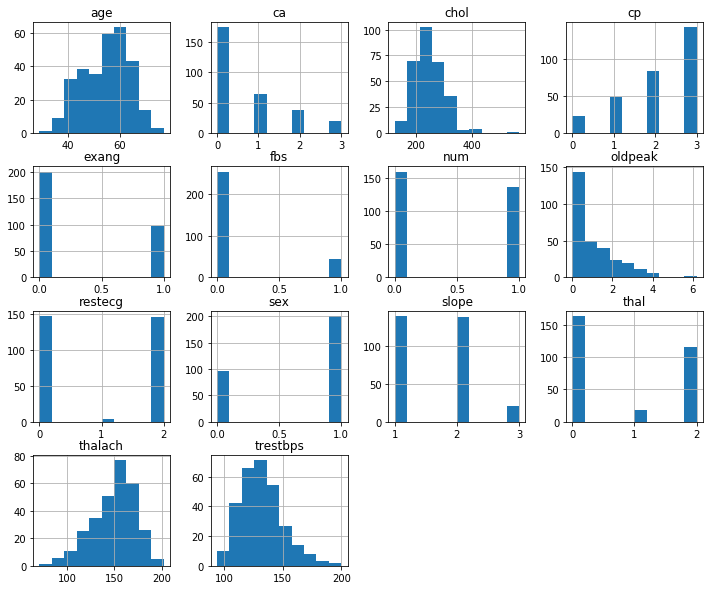

In [97]:
df.hist(figsize=(12,10))

age             AxesSubplot(0.125,0.71587;0.168478x0.16413)
sex          AxesSubplot(0.327174,0.71587;0.168478x0.16413)
cp           AxesSubplot(0.529348,0.71587;0.168478x0.16413)
trestbps     AxesSubplot(0.731522,0.71587;0.168478x0.16413)
chol           AxesSubplot(0.125,0.518913;0.168478x0.16413)
fbs         AxesSubplot(0.327174,0.518913;0.168478x0.16413)
restecg     AxesSubplot(0.529348,0.518913;0.168478x0.16413)
thalach     AxesSubplot(0.731522,0.518913;0.168478x0.16413)
exang          AxesSubplot(0.125,0.321957;0.168478x0.16413)
oldpeak     AxesSubplot(0.327174,0.321957;0.168478x0.16413)
slope       AxesSubplot(0.529348,0.321957;0.168478x0.16413)
ca          AxesSubplot(0.731522,0.321957;0.168478x0.16413)
thal              AxesSubplot(0.125,0.125;0.168478x0.16413)
num            AxesSubplot(0.327174,0.125;0.168478x0.16413)
dtype: object

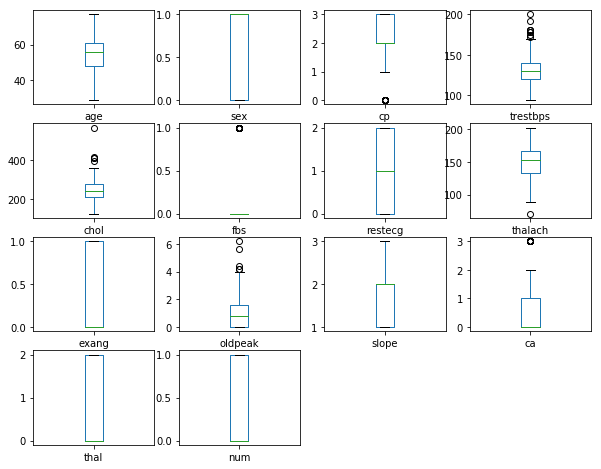

In [98]:
df.plot(kind= 'box' , subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=(10,8))

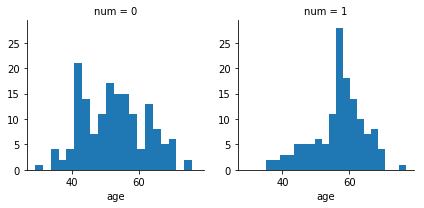

In [99]:
g = sns.FacetGrid(df, col='num')
g.map(plt.hist, 'age', bins=20)

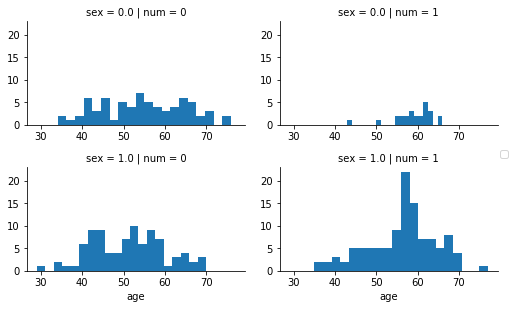

In [100]:
grid = sns.FacetGrid(df, col='num', row='sex', size=2.2, aspect=1.6)
grid.map(plt.hist, 'age', bins=20)
grid.add_legend();

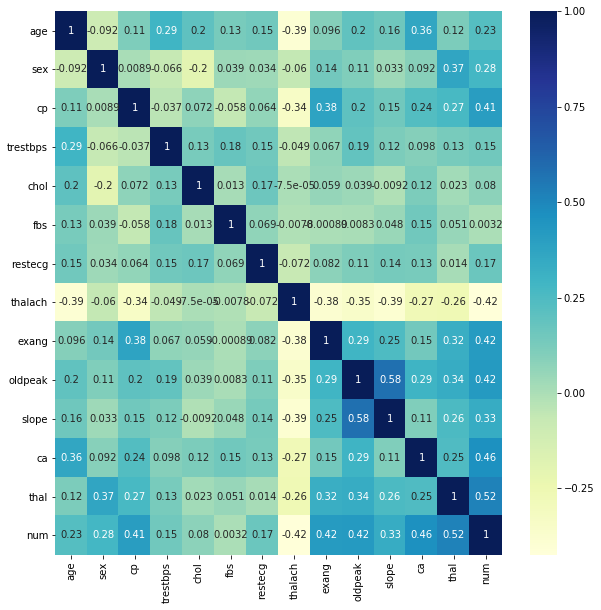

In [101]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, annot = True, cmap="YlGnBu",ax=ax)

# ax.rcParams['figure.figsize']=(20,12)
# ax.setp(ax.axes.get_xticklabels(), rotation=45)
# ax.title('Correlation Matrix for Heart Disease Data')

`fbs` and `chol` are barely correlated

<a id="feature-preprocessing"><a/>

## Feature preprocessing

In [102]:
# creating X and y
y = df['num']
df.drop('num',axis=1, inplace=True)
X = df

In [103]:
# splitting train and test
X_train, X_test, y_train, y_test = \
        train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=30)

In [104]:
# standardising the values 
stdsc = StandardScaler()
X_train = stdsc.fit_transform(X_train)
X_test = stdsc.transform(X_test)

<a id="random-forrest"></a>

## Random Forest

In [105]:
params = [
  {
      'min_samples_leaf': range(4,10,2),
      'max_features': [0.05,0.01],
      'min_samples_split': [4],
      'n_estimators': [10,100]
  }
 ]

rfc = RandomForestClassifier(random_state=55)
clf = GridSearchCV(rfc, params)
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=55, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'min_samples_leaf': range(4, 10, 2), 'max_features': [0.05, 0.01], 'min_samples_split': [4], 'n_estimators': [10, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [106]:
clf.score(X_test,y_test)

0.8666666666666667

#### Cross validation

In [107]:
predicted = cross_val_predict(clf, X, y, cv=10)
metrics.accuracy_score(y, predicted) 

0.82828282828282829

<a id="deep-learning"></a>

## Deep Learning - Multilayer perceptron

In [108]:
X_train.shape

(222, 13)

In [109]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras import optimizers

batch_size = 128
num_classes = 2
epochs = 20

X_train_keras = X_train.astype('float32')
X_test_keras = X_test.astype('float32')

y_train_keras = keras.utils.to_categorical(y_train, num_classes)
y_test_keras = keras.utils.to_categorical(y_test, num_classes)

In [117]:
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(13,)))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

history = model.fit(X_train_keras, y_train_keras,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test_keras, y_test_keras))
score = model.evaluate(X_test_keras, y_test_keras, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 100)               1400      
_________________________________________________________________
dropout_14 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_15 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_16 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 2)                 202       
Total para